# Channel Attribution using Markov Chain vs. Heuristic Model

In [13]:
import warnings
warnings.filterwarnings('ignore')

#import libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

#from pychattr.channel_attribution import MarkovModel, HeuristicModel


download data: https://www.kaggle.com/kavitabhagwani/marketing-campaign


In [2]:
#read data
marketing_campaign = pd.read_csv('marketing.csv')
marketing_campaign.head(5)


,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


### data info

In [3]:
marketing_selected = marketing_campaign[['user_id', 'date_served', 'marketing_channel', 'converted']]
print(f'Records: {len(marketing_selected)}')
marketing_campaign.describe()

Records: 10037


,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
count,10037,10021,10022,10037,10022,10037,10037,10037,1856,577,1856,1856
unique,7309,31,5,2,2,4,4,7,31,115,5,2
top,a100000882,1/15/18,House Ads,control,False,English,English,19-24 years,1/16/18,4/2/18,Instagram,True
freq,12,789,4733,5091,8946,9793,9275,1682,163,15,600,1279


### Prepare data for analysis

In [4]:
#Prepare dataset for analysis


marketing_selected['date_served'] = pd.to_datetime(marketing_selected['date_served'])
marketing_selected[["converted"]] *= 1
print(marketing_selected.dtypes)

user_id                      object
date_served          datetime64[ns]
marketing_channel            object
converted                    object
dtype: object


In [5]:
marketing_selected = marketing_selected.sort_values(['user_id', 'date_served'],
                    ascending=[True, True])
marketing_selected['visit_order'] = marketing_selected.groupby('user_id').cumcount() + 1
marketing_selected.head(5)

,user_id,date_served,marketing_channel,converted,visit_order
2380,a100000001,2018-01-14,Facebook,0,1
2381,a100000002,2018-01-14,Instagram,0,1
2382,a100000003,2018-01-14,Instagram,0,1
1815,a100000004,2018-01-01,House Ads,0,1
2383,a100000005,2018-01-14,Facebook,0,1


In [6]:
touchpoints = marketing_selected.groupby('user_id')['marketing_channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()

last_touchpoint = marketing_selected.drop_duplicates('user_id', keep='last')[['user_id', 'converted']]

paths = pd.merge(touchpoints, last_touchpoint, how='left', on='user_id')
paths = paths[paths['converted'].notna()]
paths['converted'] = paths['converted'].astype(int)
paths['Start'] = 'Start'
paths[['col1','col2' ,'col3', 'col4']] = pd.DataFrame(paths.marketing_channel.tolist(), index= paths.index)
paths['conv_str'] = ['Drop' if x== 0 else 'Conversion' for x in paths['converted']]

paths['touchpoints'] = paths[['Start', 'col1', 'col2', 'col3', 'col4', 'conv_str']].values.tolist()

def removing(element):
    val = [x for x in element['touchpoints'] if x != None]
    return val
paths['final_path'] = paths.apply(removing,axis=1)

### Dataset Observations:
* monthly data (January 2018)
* 5 unique marketing channels
* possible for users to have more than 1 entries (in cases of multiple channels before conversion/drop) 
* `date_served` should be use as the date of marketing 

In [7]:
final_df = paths[['user_id', 'final_path']]
final_df = final_df.rename({'user_id': 'cookie', 'final_path':'path'}, axis='columns')
final_df.head(5)

,cookie,path
0,a100000001,"[Start, Facebook, Drop]"
1,a100000002,"[Start, Instagram, Drop]"
2,a100000003,"[Start, Instagram, Drop]"
3,a100000004,"[Start, House Ads, Drop]"
4,a100000005,"[Start, Facebook, Drop]"


In [8]:
list_of_paths = final_df['path']
total_conversions = sum(path.count('Conversion') for path in final_df['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)
print(f'total conversions: {total_conversions}')
print(f'base conversion rate: {round(base_conversion_rate,2)}')

total conversions: 796
base conversion rate: 0.11


## Channel Attribution with Markov Chains
Functions obtained from here: https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323

In [18]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Drop']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Drop']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob

def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Drop'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Drop',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Drop'] = null_pct
            removal_df.loc['Drop']['Drop'] = 1.0

        removal_to_conv = removal_df[
            ['Drop', 'Conversion']].drop(['Drop', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Drop', 'Conversion'], axis=1).drop(['Drop', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


def calculate_markov_chains(df):    
    # Get some info for the 
    list_of_paths = df['path']
    total_conversions = sum(path.count('Conversion') for path in df['path'].tolist())
    base_conversion_rate = total_conversions / len(list_of_paths)
    
    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states)
    trans_matrix = transition_matrix(list_of_paths, trans_prob)
    
    removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)
    attributions = markov_chain_allocations(removal_effects_dict, total_conversions)
    
    # Sort attribution for plotting purposes
    attributions_sorted = {k: v for k, v in sorted(attributions.items(), key=lambda item: item[1], reverse=True)}
    
    list_of_counts = [sum(key in path for path in list_of_paths) for key in attributions_sorted.keys()]
    
    # Make dataframe for plotting purposes
    data_frame = pd.DataFrame([list(attributions_sorted.keys()), list(attributions_sorted.values()), list_of_counts]).transpose()
    data_frame.columns = ['Source', 'Attribution', 'Count']
    data_frame['Attribution / Count'] = data_frame['Attribution'] / data_frame['Count']
    data_frame = data_frame.melt(id_vars='Source').rename(columns=str.title)
    
    
    ######scaling data
    # Scale the data, just a simple example of how you might determine the scaling
    mask_attribution = data_frame['Variable'].isin(['Attribution'])
    scale_attribution = int(data_frame[~mask_attribution]['Value'].mean()
                /data_frame[mask_attribution]['Value'].mean())
    data_scaled = data_frame.copy()
    data_scaled.loc[mask_attribution, 'Value'] = data_frame.loc[mask_attribution, 'Value']*scale_attribution
    
    mask_ratio = data_scaled['Variable'].isin(['Attribution / # of messages'])
    scale_ratio = (data_frame[~mask_ratio]['Value'].mean()
                /data_frame[mask_ratio]['Value'].mean())
    data_scaled.loc[mask_ratio, 'Value'] = data_frame.loc[mask_ratio, 'Value']*scale_ratio
    
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    sns.barplot(data=data_scaled[data_scaled['Variable'] != 'Attribution / Count'], x="Source", y="Value", hue="Variable",
            ci="sd", palette="dark", alpha=.6, ax=ax[0])
    ax[0].set(ylabel='Attribution')
    ax2 = ax[0].twinx()
    ax2.set_ylim(ax[0].get_ylim())
    ax[0].set_yticklabels(np.round(ax[0].get_yticks()/scale_attribution,0))
    ax2.set_ylabel('Count')
    ax[0].set_title('Attribution and Count', fontsize=12)
    
    sns.barplot(data=data_scaled[data_scaled['Variable'] == 'Attribution / Count'],
            x="Source", y="Value", hue="Variable",
            ci="sd", palette="dark", alpha=.6, ax=ax[1])
    ax[1].set_ylabel('Attribution / Count')
    ax[1].set_title('Scaled Attribution Results', fontsize=12)

    plt.subplots_adjust(wspace=0.4)
    plt.plot()
    
    return data_scaled, data_frame, list_of_counts
    

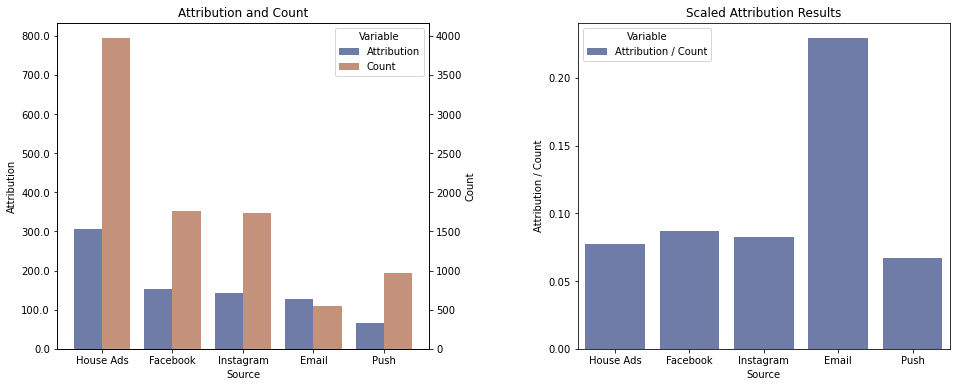

In [19]:
data_scaled, data_frame, counts = calculate_markov_chains(final_df)

## Measuring Attribution using a rule-based/heuristic model